In [44]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import random

In [37]:
waitingtimes = []

In [94]:
def task(env, name, server, processing_time):
    """task arrives, is served and leaves."""
    arrive = env.now
    with server.request() as req:
        yield req
        waiting_time = env.now-arrive
        waitingtimes.append(waiting_time)
        print('Task %s arrived at: %7.4f: ' % (name, arrive))
        yield env.timeout(processing_time)
        print('Task %s finished at %s' % (name, env.now))

In [207]:
def setup(env, arrival_rate, processing_capacity): 
    i=0
    while True:
        arrival_time = random.expovariate(arrival_rate)
        yield env.timeout(arrival_time)
        
        processing_time = random.expovariate(processing_capacity)
        env.process(task(env, i, server, processing_time))
        i += 1

In [205]:
env = simpy.Environment()
server = simpy.Resource(env, capacity=1)
arrival_rate = 0.99999
capacity = 1
server_util = arrival_rate/capacity
number_of_samples = 10000
sim_time = number_of_samples/arrival_rate
waitingtimes = []
env.process(setup(env, arrival_rate, capacity))
env.run(until=sim_time)

Task 0 arrived at:  1.9924: 
Task 0 finished at 5.301369501522031
Task 1 arrived at:  2.4054: 
Task 1 finished at 6.85481310103645
Task 2 arrived at:  2.7219: 
Task 2 finished at 7.15115504913602
Task 3 arrived at:  3.8096: 
Task 3 finished at 10.326379768781251
Task 4 arrived at:  5.8684: 
Task 4 finished at 10.79781454144889
Task 5 arrived at:  6.6438: 
Task 5 finished at 10.910812519646303
Task 6 arrived at:  7.5975: 
Task 6 finished at 11.144648919032987
Task 7 arrived at:  7.9165: 
Task 7 finished at 15.323084956340438
Task 8 arrived at: 10.2150: 
Task 8 finished at 16.432450450852592
Task 9 arrived at: 11.5819: 
Task 9 finished at 16.44612493189914
Task 10 arrived at: 12.2875: 
Task 10 finished at 17.303515245198906
Task 11 arrived at: 12.5250: 
Task 11 finished at 18.559339938845934
Task 12 arrived at: 12.9965: 
Task 12 finished at 20.005129986915605
Task 13 arrived at: 13.4384: 
Task 13 finished at 20.305827820238502
Task 14 arrived at: 13.6529: 
Task 14 finished at 22.29961550

Task 1303 finished at 1319.7959603328457
Task 1304 arrived at: 1270.4877: 
Task 1304 finished at 1319.8150516991986
Task 1305 arrived at: 1270.9717: 
Task 1305 finished at 1320.1605161331302
Task 1306 arrived at: 1271.2184: 
Task 1306 finished at 1320.4719588382832
Task 1307 arrived at: 1271.7456: 
Task 1307 finished at 1321.960116287614
Task 1308 arrived at: 1272.6646: 
Task 1308 finished at 1322.3244875385622
Task 1309 arrived at: 1274.7359: 
Task 1309 finished at 1323.8514004336234
Task 1310 arrived at: 1275.5483: 
Task 1310 finished at 1326.768239155642
Task 1311 arrived at: 1276.4887: 
Task 1311 finished at 1326.9535299185275
Task 1312 arrived at: 1276.7290: 
Task 1312 finished at 1327.2362611403037
Task 1313 arrived at: 1276.8938: 
Task 1313 finished at 1329.8878851496006
Task 1314 arrived at: 1277.0382: 
Task 1314 finished at 1336.1871460161117
Task 1315 arrived at: 1277.7214: 
Task 1315 finished at 1336.2854891912893
Task 1316 arrived at: 1278.1271: 
Task 1316 finished at 1339.

Task 2412 arrived at: 2344.8677: 
Task 2412 finished at 2397.1607932731663
Task 2413 arrived at: 2345.1253: 
Task 2413 finished at 2397.255005623332
Task 2414 arrived at: 2346.7683: 
Task 2414 finished at 2400.0038237146655
Task 2415 arrived at: 2346.9959: 
Task 2415 finished at 2401.6090244090196
Task 2416 arrived at: 2348.4083: 
Task 2416 finished at 2401.683343445574
Task 2417 arrived at: 2348.6331: 
Task 2417 finished at 2401.981799948993
Task 2418 arrived at: 2348.8407: 
Task 2418 finished at 2402.431231373056
Task 2419 arrived at: 2349.3323: 
Task 2419 finished at 2402.436503687397
Task 2420 arrived at: 2349.6503: 
Task 2420 finished at 2402.5937175245335
Task 2421 arrived at: 2349.8697: 
Task 2421 finished at 2403.264416337652
Task 2422 arrived at: 2353.0206: 
Task 2422 finished at 2403.463149223448
Task 2423 arrived at: 2354.7413: 
Task 2423 finished at 2403.635528972342
Task 2424 arrived at: 2355.0589: 
Task 2424 finished at 2403.8161828388165
Task 2425 arrived at: 2355.5404: 

Task 3661 finished at 3644.2134632860607
Task 3662 arrived at: 3643.3710: 
Task 3662 finished at 3645.246614697792
Task 3663 arrived at: 3643.9113: 
Task 3663 finished at 3645.628704488727
Task 3664 arrived at: 3644.2937: 
Task 3664 finished at 3646.384474546429
Task 3665 arrived at: 3644.8387: 
Task 3665 finished at 3647.068207634588
Task 3666 arrived at: 3649.4263: 
Task 3666 finished at 3649.7378210852376
Task 3667 arrived at: 3649.4348: 
Task 3667 finished at 3650.5122596643073
Task 3668 arrived at: 3649.4723: 
Task 3668 finished at 3651.7238424946713
Task 3669 arrived at: 3650.1051: 
Task 3669 finished at 3653.6406515400977
Task 3670 arrived at: 3650.3219: 
Task 3670 finished at 3654.1179043287793
Task 3671 arrived at: 3653.0320: 
Task 3671 finished at 3654.1360021617716
Task 3672 arrived at: 3653.2508: 
Task 3672 finished at 3654.200501496807
Task 3673 arrived at: 3653.4683: 
Task 3673 finished at 3654.569610656775
Task 3674 arrived at: 3654.8931: 
Task 3674 finished at 3658.4376

Task 4911 finished at 4931.47629753829
Task 4912 arrived at: 4888.0391: 
Task 4912 finished at 4932.700799037954
Task 4913 arrived at: 4888.6274: 
Task 4913 finished at 4933.407497352336
Task 4914 arrived at: 4889.4981: 
Task 4914 finished at 4933.78376683024
Task 4915 arrived at: 4891.4539: 
Task 4915 finished at 4933.86937207306
Task 4916 arrived at: 4891.9616: 
Task 4916 finished at 4933.955059617017
Task 4917 arrived at: 4892.6449: 
Task 4917 finished at 4935.190753520122
Task 4918 arrived at: 4892.8267: 
Task 4918 finished at 4936.4867784056005
Task 4919 arrived at: 4893.3331: 
Task 4919 finished at 4936.922521137713
Task 4920 arrived at: 4894.5096: 
Task 4920 finished at 4937.066922754093
Task 4921 arrived at: 4895.3794: 
Task 4921 finished at 4938.486817114421
Task 4922 arrived at: 4897.0240: 
Task 4922 finished at 4939.325055978457
Task 4923 arrived at: 4898.1808: 
Task 4923 finished at 4939.404545150563
Task 4924 arrived at: 4898.7813: 
Task 4924 finished at 4939.605265376869


Task 6161 arrived at: 6119.3443: 
Task 6161 finished at 6132.835183006585
Task 6162 arrived at: 6119.3618: 
Task 6162 finished at 6134.115124003653
Task 6163 arrived at: 6121.3289: 
Task 6163 finished at 6135.378503896011
Task 6164 arrived at: 6121.4191: 
Task 6164 finished at 6135.458982600074
Task 6165 arrived at: 6121.9615: 
Task 6165 finished at 6135.473919624605
Task 6166 arrived at: 6123.2543: 
Task 6166 finished at 6135.684108463006
Task 6167 arrived at: 6124.7720: 
Task 6167 finished at 6135.708490433582
Task 6168 arrived at: 6126.9087: 
Task 6168 finished at 6136.364444761414
Task 6169 arrived at: 6128.7101: 
Task 6169 finished at 6137.674326338915
Task 6170 arrived at: 6128.7321: 
Task 6170 finished at 6138.269890710281
Task 6171 arrived at: 6129.1504: 
Task 6171 finished at 6138.704558448333
Task 6172 arrived at: 6129.2258: 
Task 6172 finished at 6140.002784097992
Task 6173 arrived at: 6129.5098: 
Task 6173 finished at 6141.259543594004
Task 6174 arrived at: 6130.4846: 
Task

Task 7411 arrived at: 7299.0343: 
Task 7411 finished at 7374.87764035791
Task 7412 arrived at: 7300.3629: 
Task 7412 finished at 7375.249114799274
Task 7413 arrived at: 7300.9505: 
Task 7413 finished at 7375.872163572526
Task 7414 arrived at: 7303.2659: 
Task 7414 finished at 7379.488631287345
Task 7415 arrived at: 7303.4603: 
Task 7415 finished at 7380.211491053813
Task 7416 arrived at: 7304.1572: 
Task 7416 finished at 7381.440984466934
Task 7417 arrived at: 7304.2661: 
Task 7417 finished at 7383.299750436427
Task 7418 arrived at: 7305.3698: 
Task 7418 finished at 7384.114286691917
Task 7419 arrived at: 7306.0608: 
Task 7419 finished at 7385.646540444042
Task 7420 arrived at: 7306.2167: 
Task 7420 finished at 7386.0579057424175
Task 7421 arrived at: 7306.4647: 
Task 7421 finished at 7386.518100881116
Task 7422 arrived at: 7307.7352: 
Task 7422 finished at 7387.552403044749
Task 7423 arrived at: 7311.4362: 
Task 7423 finished at 7388.0261852288095
Task 7424 arrived at: 7314.1537: 
Tas

Task 8660 finished at 8661.324099190466
Task 8661 arrived at: 8523.3607: 
Task 8661 finished at 8665.007761534996
Task 8662 arrived at: 8523.5167: 
Task 8662 finished at 8665.447652983536
Task 8663 arrived at: 8523.5430: 
Task 8663 finished at 8665.66930457394
Task 8664 arrived at: 8523.5795: 
Task 8664 finished at 8665.68174427968
Task 8665 arrived at: 8525.2524: 
Task 8665 finished at 8666.168130669113
Task 8666 arrived at: 8528.4715: 
Task 8666 finished at 8667.373295433195
Task 8667 arrived at: 8528.5916: 
Task 8667 finished at 8667.636774536917
Task 8668 arrived at: 8528.6802: 
Task 8668 finished at 8670.030138989074
Task 8669 arrived at: 8529.1370: 
Task 8669 finished at 8670.378349004213
Task 8670 arrived at: 8529.7829: 
Task 8670 finished at 8671.463837760095
Task 8671 arrived at: 8530.0586: 
Task 8671 finished at 8672.695964670685
Task 8672 arrived at: 8531.3495: 
Task 8672 finished at 8673.05256433057
Task 8673 arrived at: 8531.6555: 
Task 8673 finished at 8673.231825508588
T

Task 9910 finished at 9923.834752738587
Task 9911 arrived at: 9817.6179: 
Task 9911 finished at 9925.54897400302
Task 9912 arrived at: 9819.9480: 
Task 9912 finished at 9925.91833901795
Task 9913 arrived at: 9825.4093: 
Task 9913 finished at 9926.386492943411
Task 9914 arrived at: 9825.7822: 
Task 9914 finished at 9927.1907083191
Task 9915 arrived at: 9826.2395: 
Task 9915 finished at 9927.637444563567
Task 9916 arrived at: 9829.1732: 
Task 9916 finished at 9927.834175044627
Task 9917 arrived at: 9829.4375: 
Task 9917 finished at 9927.896058353504
Task 9918 arrived at: 9830.5091: 
Task 9918 finished at 9928.343715962852
Task 9919 arrived at: 9831.1653: 
Task 9919 finished at 9929.207483417948
Task 9920 arrived at: 9831.2506: 
Task 9920 finished at 9929.3033852654
Task 9921 arrived at: 9831.8753: 
Task 9921 finished at 9929.501733332158
Task 9922 arrived at: 9832.0983: 
Task 9922 finished at 9930.118222258681
Task 9923 arrived at: 9832.5440: 
Task 9923 finished at 9931.076930898083
Task

50.733640583984396 3.8828216784635535e-08
99999.0000004551


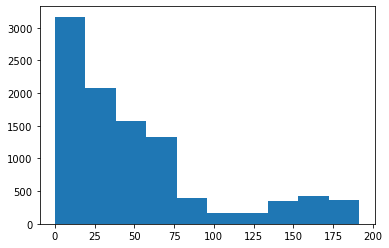

In [208]:
plt.hist(waitingtimes)
mean = np.mean(waitingtimes)
var = 1/(len(waitingtimes)*mean**2)
print(mean, var)
print((server_util/capacity)/(1-server_util))